In [1]:
import os
import matplotlib
import fiona

import rsfuncs as rs
import numpy as np
import pandas as pd
import rasterio as rio
import geopandas as gp
import matplotlib.pyplot as plt

from tqdm import tqdm
from datetime import datetime, timedelta
from rasterio import features, mask
from dateutil.relativedelta import relativedelta

In [2]:
# Find SWE files
data_dir = "../data/LRM_SWE_monthly"
files = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if x.endswith(".tif")]
files.sort()

# Read shapefile
shp = fiona.open("../shape/sierra_catchments.shp", "r")

# Extract geoms for sheds we are interested in
shed_geoms = {}
for shed in shp:
    catch_name = shed['properties']['catch_name']
    if "TULE" in catch_name:
        sh_geom = shed['geometry']
        outlet_id = shed['properties']['stid']
        shed_geoms[outlet_id] = sh_geom
    if "KAWEAH" in catch_name:
        sh_geom = shed['geometry']
        outlet_id = shed['properties']['stid']
        shed_geoms[outlet_id] = sh_geom
#     if "KING" in catch_name:
#         sh_geom = shed['geometry']
#         outlet_id = shed['properties']['stid']
#         shed_geoms[outlet_id] = sh_geom

In [3]:
def get_LRM_swe(geom):

    # Read the files, mask nans, clip to CVWS, extract dates
    imdict = {}

    for i in tqdm(files[:]):
        date = datetime.strptime(i[-12:-4],'%Y%m%d')+ timedelta(days=-1) # Get the date 
        datestr = date.strftime('%Y%m%d') # Format date
        src = rio.open(i) # Read file
        src2 = rio.mask.mask(src, geom, crop=True) # Clip to CVWS 
        arr = src2[0] # read as array
        arr = arr.reshape(arr.shape[1], arr.shape[2]) # Reshape bc rasterio has a different dim ordering 
        arr[arr < 0 ] = np.nan # Mask nodata vals 
        imdict[datestr] = arr
        
    # Fill in the dates with no SWE with nans 
    dt_idx = pd.date_range(list(imdict.keys())[0], list(imdict.keys())[-1], freq = "M")

    all_dates = {}

    for i in dt_idx:
        date = i.strftime("%Y%m%d") 

        if date in imdict.keys():
            im = imdict[date]
        else:
            im = np.zeros_like(list(imdict.values())[0])
            im[im==0] = np.nan
        all_dates[date] = im
        
    swestack = np.dstack(list(all_dates.values()))

    # Compute monthly sums
    swesums = []
    for i in range(swestack.shape[2]):
        swesums.append(np.nansum(swestack[:,:,i] *500**2 * 1e-9)) # mult by 2500m pixel area, convert m^3 to km^3

    # Make dataframe and write 
    swedf = pd.DataFrame(swesums, index = dt_idx)
    swedf.columns = ["SWE_km3"]
    
    return swedf



In [4]:
shed_swe_sums = {}
for k,v in shed_geoms.items():
    swedf = get_LRM_swe([v]) # NEEDS to be a list 
    shed_swe_sums[k] = swedf

100%|██████████| 116/116 [00:00<00:00, 117.08it/s]


<AxesSubplot:>

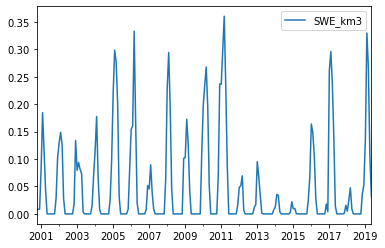

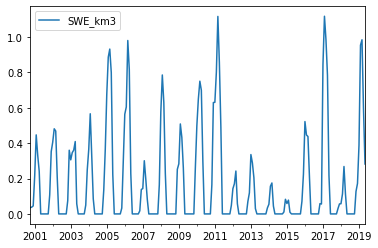

In [5]:
shed_swe_sums['SCC'].plot()
shed_swe_sums['TRM'].plot()

In [6]:
shed_swe_sums['SCC'].to_csv("../data/SCC_lrm_swe.csv")
shed_swe_sums['TRM'].to_csv("../data/TRM_lrm_swe.csv")

In [7]:
# Process SNODAS

In [8]:
# Load preprocessed snodas arrays
snodas_trm = np.load("../data/TRM_swe.npy")
snodas_scc = np.load("../data/SCC_swe.npy")

In [9]:
# Make datetime index 
dt_idx = pd.date_range("2003-09-30","2020-10-01", freq = "D")
idxdf = pd.DataFrame(pd.to_datetime(dt_idx))
idxdf.columns = ['date']
idxdf['counter'] = idxdf.index
# Setup the cols 
idxdf.index = idxdf['date']
idxdf['month'] = idxdf.index.month
idxdf['day'] = idxdf.index.day
# record the indices for first of each month 
monthfirst_idx = idxdf[idxdf['day'] == 1].counter.values


In [10]:
# Loop through indices and select slices from numpy array 
snodas_trm_proc = []
snodas_scc_proc = []

for idx in tqdm(monthfirst_idx):
    snodas_trm_proc.append(snodas_trm[:,:,idx])
    snodas_scc_proc.append(snodas_scc[:,:,idx])
    

100%|██████████| 205/205 [00:00<00:00, 379616.92it/s]


In [11]:
trmstack = np.dstack(snodas_trm_proc)
sccstack = np.dstack(snodas_scc_proc)

In [12]:
trm_sums = []
scc_sums = []

for m in range(0,trmstack.shape[2]):
    msum_trm = np.nansum(trmstack[:,:,m]) / 1000
    msum_scc = np.nansum(sccstack[:,:,m]) / 1000
    trm_sums.append(msum_trm)
    scc_sums.append(msum_scc)

In [13]:
dt_idx_sno = pd.date_range("2003-09-30",'2020-10-30', freq = "M")
snodf = pd.DataFrame([trm_sums,scc_sums]).T
snodf.index = dt_idx_sno
snodf.columns = ['TRM', 'SCC']

<AxesSubplot:>

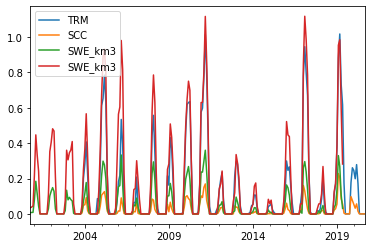

In [14]:
ax = snodf.plot()
shed_swe_sums['SCC'].plot(ax=ax)
shed_swe_sums['TRM'].plot(ax=ax)